## Import + Load processed data

In [1]:
import pandas as pd

train_path = "../data/processed/train.csv"
val_path   = "../data/processed/val.csv"
test_path  = "../data/processed/test.csv"

train_df = pd.read_csv(train_path)
val_df   = pd.read_csv(val_path)
test_df  = pd.read_csv(test_path)

X_train, y_train = train_df["text"].astype(str), train_df["label"].astype(int)
X_val,   y_val   = val_df["text"].astype(str),   val_df["label"].astype(int)
X_test,  y_test  = test_df["text"].astype(str),  test_df["label"].astype(int)

print("Train:", train_df.shape, "Val:", val_df.shape, "Test:", test_df.shape)
train_df.head()

Train: (35918, 2) Val: (4490, 2) Test: (4490, 2)


,text,label
0,trump asks supreme court to block travel ban r...,0
1,insight emails show how republicans lobbied to...,0
2,jailed british iranian charity worker received...,0
3,trump gets torn to shreds after his fake news ...,1
4,trump offers support for bathroom access based...,0


## Tokenization + Padding (khusus LSTM)

In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

VOCAB_SIZE = 30000
MAX_LEN = 300
OOV_TOKEN = "<OOV>"

tokenizer = Tokenizer(num_words=VOCAB_SIZE, oov_token=OOV_TOKEN)
tokenizer.fit_on_texts(X_train)

train_seq = tokenizer.texts_to_sequences(X_train)
val_seq   = tokenizer.texts_to_sequences(X_val)
test_seq  = tokenizer.texts_to_sequences(X_test)

X_train_pad = pad_sequences(train_seq, maxlen=MAX_LEN, padding="post", truncating="post")
X_val_pad   = pad_sequences(val_seq,   maxlen=MAX_LEN, padding="post", truncating="post")
X_test_pad  = pad_sequences(test_seq,  maxlen=MAX_LEN, padding="post", truncating="post")

print("Padded shape:", X_train_pad.shape, X_val_pad.shape, X_test_pad.shape)


Padded shape: (35918, 300) (4490, 300) (4490, 300)


## Build model LSTM (Non-Pretrained)

In [3]:
from tensorflow.keras import layers, models

EMBED_DIM = 128
LSTM_UNITS = 128
DROPOUT = 0.3

model = models.Sequential([
    layers.Embedding(input_dim=VOCAB_SIZE, output_dim=EMBED_DIM, input_length=MAX_LEN),
    layers.Bidirectional(layers.LSTM(LSTM_UNITS, return_sequences=False)),
    layers.Dropout(DROPOUT),
    layers.Dense(64, activation="relu"),
    layers.Dropout(DROPOUT),
    layers.Dense(1, activation="sigmoid")
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 128)          3840000   
                                                                 
 bidirectional (Bidirection  (None, 256)               263168    
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense (Dense)               (None, 64)                16448     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                       

## Training + Callbacks (EarlyStopping + Save Best)

In [4]:
import os
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

os.makedirs("../models", exist_ok=True)

ckpt_path = "../models/lstm_best.h5"

callbacks = [
    EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True),
    ModelCheckpoint(ckpt_path, monitor="val_loss", save_best_only=True)
]

history = model.fit(
    X_train_pad, y_train,
    validation_data=(X_val_pad, y_val),
    epochs=10,
    batch_size=128,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/10


281/281 [==============================] - 193s 678ms/step - loss: 0.0676 - accuracy: 0.9687 - val_loss: 0.0080 - val_accuracy: 0.9976
Epoch 2/10


c:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


281/281 [==============================] - 193s 687ms/step - loss: 0.0014 - accuracy: 0.9997 - val_loss: 0.0036 - val_accuracy: 0.9993
Epoch 3/10
281/281 [==============================] - 194s 689ms/step - loss: 4.6367e-04 - accuracy: 0.9999 - val_loss: 0.0078 - val_accuracy: 0.9982
Epoch 4/10
281/281 [==============================] - 194s 689ms/step - loss: 8.3526e-05 - accuracy: 1.0000 - val_loss: 0.0066 - val_accuracy: 0.9989
Epoch 5/10
281/281 [==============================] - 196s 697ms/step - loss: 2.8466e-05 - accuracy: 1.0000 - val_loss: 0.0063 - val_accuracy: 0.9987


## Plot Loss & Accuracy

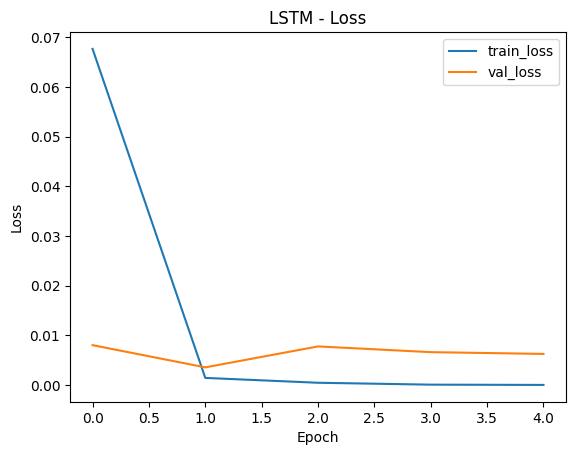

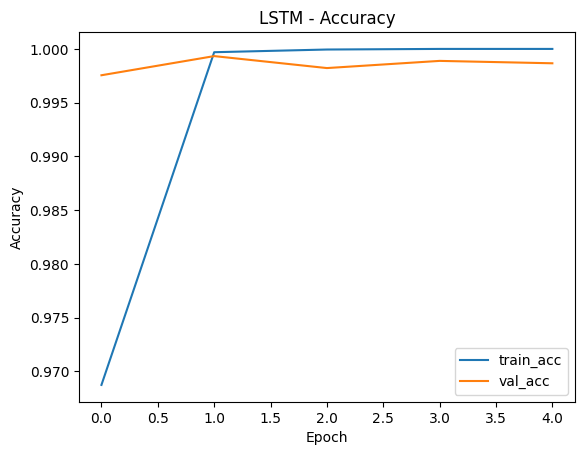

In [5]:
import matplotlib.pyplot as plt

# Loss
plt.figure()
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.title("LSTM - Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Accuracy
plt.figure()
plt.plot(history.history["accuracy"], label="train_acc")
plt.plot(history.history["val_accuracy"], label="val_acc")
plt.title("LSTM - Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

## Evaluation: Classification Report + Confusion Matrix

Classification Report (LSTM):
              precision    recall  f1-score   support

        Real       1.00      1.00      1.00      2142
        Fake       1.00      1.00      1.00      2348

    accuracy                           1.00      4490
   macro avg       1.00      1.00      1.00      4490
weighted avg       1.00      1.00      1.00      4490



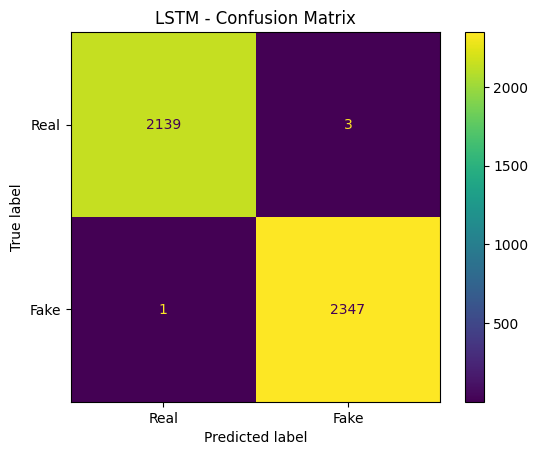

In [6]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Predict
y_prob = model.predict(X_test_pad, verbose=0).ravel()
y_pred = (y_prob >= 0.5).astype(int)

print("Classification Report (LSTM):")
print(classification_report(y_test, y_pred, target_names=["Real", "Fake"]))

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Real", "Fake"])
disp.plot()
plt.title("LSTM - Confusion Matrix")
plt.show()

## Save tokenizer

In [7]:
import joblib

tokenizer_path = "../models/lstm_tokenizer.joblib"
joblib.dump(tokenizer, tokenizer_path)

print("Saved model:", ckpt_path)
print("Saved tokenizer:", tokenizer_path)

Saved model: ../models/lstm_best.h5
Saved tokenizer: ../models/lstm_tokenizer.joblib
